# Sista notebooken!

Nu jagar jag max accuracy - inte för att det är viktigt, men för att det är lite kul ... :D

In [ ]:
# Import av alla nödvändiga paket

# Tidsmätning
import time
notebook_start = time.time()  
t0 = time.time()

# Baspaket för data och analys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset och modellval
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Bildbehandling
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter, map_coordinates
from PIL import Image

# Spara och ladda modeller
import joblib
import os

# Tidshantering för cellen
cell_time = time.time() - t0
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int((time.time() - notebook_start) // 60)} minuter och {int((time.time() - notebook_start) % 60)} sekunder")

>>> Tid för denna cell: 2.7 sekunder
>>> Total tid sedan start: 0 minuter och 2 sekunder


Läs in data, normalisera och kör deskew (för att få mer enhetliga data)

In [ ]:
t0 = time.time()

# 1. Hämta MNIST-data 
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False, parser='auto')
X = mnist["data"]              
y = mnist["target"].astype(np.uint8)

# 2. Normalisera direkt till [0, 1]
X = X / 255.0

# 3. Stratifierad split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Deskew-funktion
def deskew(image):
    img = image.reshape(28, 28)
    mu = ndimage.center_of_mass(img)
    if np.isnan(mu).any():
        return img.flatten()
    
    # Beräkna kovarians/varians för att hitta lutningen (skew)
    y_coords, x_coords = np.mgrid[:28, :28]
    mu11 = np.sum((x_coords - mu[1]) * (y_coords - mu[0]) * img)
    mu02 = np.sum((y_coords - mu[0])**2 * img)
    
    if abs(mu02) < 1e-2:
        return img.flatten()
    
    skew = mu11 / mu02
    matrix = np.array([[1, 0], [skew, 1]])
    center = np.array([14, 14])
    offset = center - np.dot(matrix, center)
    
    # Transformera bilden
    img_deskewed = ndimage.affine_transform(img, matrix, offset=offset, order=1, mode='constant', cval=0)
    return img_deskewed.flatten()

# Applicera Deskewing på träningssetet direkt
print("Rätar upp träningsbilder (Deskewing)...")
X_train_deskewed = np.array([deskew(img) for img in X_train])

# Tidshantering
cell_time = time.time() - t0
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int((time.time() - notebook_start) // 60)} minuter och {int((time.time() - notebook_start) % 60)} sekunder")

Rätar upp träningsbilder (Deskewing)...
>>> Tid för denna cell: 7.8 sekunder
>>> Total tid sedan start: 0 minuter och 10 sekunder


Modellen får lite extradata att tugga i sig

In [ ]:
t0 = time.time()

# Sökvägar
paths = {
    'custom': 'collected_data',
    'errors': 'mnist_errors'
}

X_extra = []
y_extra = []

def process_and_add(folder, label_pos, split_char='_'):
    added_count = 0
    if not os.path.exists(folder):
        print(f"VARNING: Mappen '{folder}' hittades inte!")
        return 0
    
    files = [f for f in os.listdir(folder) if f.endswith(".png")]
    print(f"Hittade {len(files)} st .png-filer i {folder}...")

    for filename in files:
        try:
            # Extrahera label baserat på filnamnsstruktur
            parts = filename.split(split_char)
            # Hitta siffran i filnamnet
            label = None
            for p in parts:
                if p.isdigit() and len(p) == 1:
                    label = int(p)
                    break
            
            if label is None:
                # Fallback
                label = int(parts[label_pos])
            
            # Bearbeta bilden till MNIST-format
            img = Image.open(os.path.join(folder, filename)).convert('L')
            img = img.resize((28, 28), Image.Resampling.LANCZOS)
            img_array = np.array(img).astype(np.float32) / 255.0
            
            # MNIST-standard: Vit siffra på svart bakgrund
            # Kolla medianen av kanterna
            edge_median = np.median(np.concatenate([img_array[0,:], img_array[-1,:], img_array[:,0], img_array[:,-1]]))
            # Ljus bakgrund -> Invertera
            if edge_median > 0.5: 
                img_array = 1.0 - img_array
                
            X_extra.append(img_array.flatten())
            y_extra.append(label)
            added_count += 1
        except Exception as e:
            print(f"Skippar {filename}: {e}")
            
    return added_count

# Läs in användarskapade bilder
count_c = process_and_add(paths['custom'], label_pos=1)

# Läs in de sämsta bilderna
count_e = process_and_add(paths['errors'], label_pos=1)

if len(X_extra) > 0:
    X_train = np.vstack([X_train, np.array(X_extra)])
    y_train = np.concatenate([y_train, np.array(y_extra)])
    print("-" * 30)
    print(f"SUCCESS: Inkluderat {count_c} egna bilder och {count_e} svåra specialfall.")
    print(f"Nytt antal i X_train: {len(X_train)} (ökning med {len(X_extra)})")
else:
    print("-" * 30)
    print("INGA EXTRA BILDER TILLGÅNGNA. Kontrollera mapparna!")

# Uppdatera X_train_deskewed med alla bilder
print("Rätar upp det nya kombinerade träningssetet (Deskewing)...")
X_train_deskewed = np.array([deskew(img) for img in X_train])

cell_time = time.time() - t0
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")

Hittade 18 st .png-filer i collected_data...
Hittade 50 st .png-filer i mnist_errors...
------------------------------
SUCCESS: Inkluderat 18 egna bilder och 50 svåra specialfall.
Nytt antal i X_train: 56068 (ökning med 68)
Rätar upp det nya kombinerade träningssetet (Deskewing)...
>>> Tid för denna cell: 4.8 sekunder


Augmentering. Nu tar jag till storsläggan med skiftningar, rotationer och zoom kompletterade med elastisk deformation. 

In [ ]:
t0 = time.time()

# Basfunktioner
def shift_image(image, dx, dy):
    return ndimage.shift(image.reshape(28, 28), [dy, dx], cval=0, mode="constant").flatten()

def rotate_image(image, angle):
    return ndimage.rotate(image.reshape(28, 28), angle, reshape=False, cval=0, mode="constant").flatten()

def zoom_image(image, zoom_factor):
    # Zooma genom att skala om och sedan klippa/vaddera tillbaka till 28x28
    img = image.reshape(28, 28)
    h, w = img.shape
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
    
    # Skalning
    zoomed = ndimage.zoom(img, zoom_factor, order=1)
    
    # Justera storlek till exakt 28x28
    if zoom_factor < 1.0: 
        # Vaddera
        pad_h = (h - zoomed.shape[0]) // 2
        pad_w = (w - zoomed.shape[1]) // 2
        result = np.pad(zoomed, ((pad_h, h - zoomed.shape[0] - pad_h), (pad_w, w - zoomed.shape[1] - pad_w)), mode='constant')
    else: 
        # Klipp
        start_h = (zoomed.shape[0] - h) // 2
        start_w = (zoomed.shape[1] - w) // 2
        result = zoomed[start_h:start_h+h, start_w:start_w+w]
    return result.flatten()

# Elastisk deformation
def elastic_transform(image, alpha=36, sigma=4):
    shape = (28, 28)
    image_2d = image.reshape(shape)
    random_state = np.random.RandomState(None)
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    y, x = np.mgrid[0:shape[0], 0:shape[1]]
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    return map_coordinates(image_2d, indices, order=1, mode='constant', cval=0).flatten()

# Augmentering start
print(f"Startar Super-Ultra Augmentering av bilderna.")
X_train_aug = [X_train_deskewed]
y_train_aug = [y_train]

# Skifta åt fyra håll
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    X_train_aug.append(np.apply_along_axis(shift_image, 1, X_train_deskewed, dx, dy))
    y_train_aug.append(y_train)

# Rotera (+/- 4, 8, 12 grader)
for angle in (4, -4, 8, -8, 12, -12):
    X_train_aug.append(np.apply_along_axis(rotate_image, 1, X_train_deskewed, angle))
    y_train_aug.append(y_train)

# Zooma (0.9 och 1.1)
for z in (0.9, 1.1):
    X_train_aug.append(np.apply_along_axis(zoom_image, 1, X_train_deskewed, z))
    y_train_aug.append(y_train)

# Elastisk Deformation (två varianter)
for _ in range(2):
    X_train_aug.append(np.apply_along_axis(elastic_transform, 1, X_train_deskewed))
    y_train_aug.append(y_train)

# Sammanfoga och blanda
X_train_augmented = np.concatenate(X_train_aug)
y_train_augmented = np.concatenate(y_train_aug)
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

print(f"Augmentering klar! Nytt antal rader: {len(X_train_augmented)}")

# Tidshantering
cell_time = time.time() - t0
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int((time.time() - notebook_start) // 60)} minuter och {int((time.time() - notebook_start) % 60)} sekunder")

Startar Super-Ultra Augmentering av bilderna.
Augmentering klar! Nytt antal rader: 841020
>>> Tid för denna cell: 70.7 sekunder
>>> Total tid sedan start: 9 minuter och 49 sekunder


Med så här många rader blir bearbetningen tidskrävande. Dimensionsreducering *to the rescue*!

Startar PCA-analys på det augmenterade setet (841020 rader)...
------------------------------
Antal komponenter för 95% varians: 112
Antal komponenter för 99% varians: 265
------------------------------


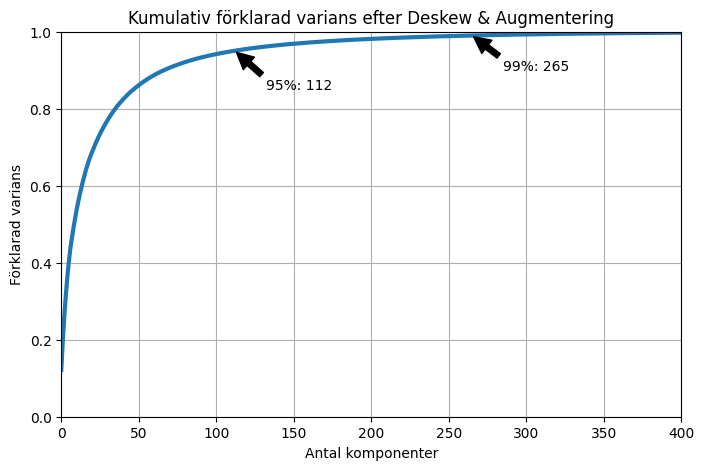

>>> Tid för denna cell: 3.2 sekunder
>>> Total tid sedan start: 10 minuter och 0 sekunder


In [ ]:
t0 = time.time()

print(f"Startar PCA-analys på det augmenterade setet ({X_train_augmented.shape[0]} rader)...")

# PCA utan att ange n_components för att se hela varianskurvan
pca_full = PCA()
pca_full.fit(X_train_augmented)

# Beräkna kumulativ förklarad varians
cumsum = np.cumsum(pca_full.explained_variance_ratio_)

# Hitta brytpunkterna för 95% och 99% varians
d_95 = np.argmax(cumsum >= 0.95) + 1
d_99 = np.argmax(cumsum >= 0.99) + 1

print("-" * 30)
print(f"Antal komponenter för 95% varians: {d_95}")
print(f"Antal komponenter för 99% varians: {d_99}")
print("-" * 30)

# Visualisering av varianskurvan
plt.figure(figsize=(8, 5))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Antal komponenter")
plt.ylabel("Förklarad varians")
plt.annotate(f'95%: {d_95}', xy=(d_95, 0.95), xytext=(d_95+20, 0.85),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'99%: {d_99}', xy=(d_99, 0.99), xytext=(d_99+20, 0.90),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.grid(True)
plt.title("Kumulativ förklarad varians efter Deskew & Augmentering")
plt.show()

# Tidshantering
cell_time = time.time() - t0
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int((time.time() - notebook_start) // 60)} minuter och {int((time.time() - notebook_start) % 60)} sekunder")

Preparera testsetet för korrekt jämförelse.

In [ ]:
t0 = time.time()

print(f"Förbereder {len(X_test)} testbilder (endast Deskewing)...")

# Räta upp testbilderna så att de matchar modellens förväntade indata
X_test_deskewed = np.array([deskew(img) for img in X_test])

print(f"Testset klart. Form: {X_test_deskewed.shape}")

# Tidshantering
cell_time = time.time() - t0
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int((time.time() - notebook_start) // 60)} minuter och {int((time.time() - notebook_start) % 60)} sekunder")

Förbereder 14000 testbilder (endast Deskewing)...
Testset klart. Form: (14000, 784)
>>> Tid för denna cell: 1.2 sekunder
>>> Total tid sedan start: 165 minuter och 46 sekunder


En pipeline för hanteringen - här är hyperparametrarna uppdaterade efter ett gäng experimentkörningar längre ned.

In [ ]:
t0 = time.time()

# 112 komponenter täcker 95 % av variansen och höll hög prestanda i tidigare experiment
n_components_chosen = 112 

print(f"Konfigurerar pipeline med PCA ({n_components_chosen} komponenter) och SVC (C=25, RBF)...")

# Pipelinen säkerställer att PCA-transformationen sker likadant för alla data
mnist_pipeline = Pipeline([
    ('pca', PCA(n_components=n_components_chosen, random_state=42)),
    ('svc', SVC(C=25, kernel='rbf', gamma='scale', probability=True, random_state=42))
])

# Tidshantering
cell_time = time.time() - t0
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int((time.time() - notebook_start) // 60)} minuter och {int((time.time() - notebook_start) % 60)} sekunder")

Konfigurerar pipeline med PCA (112 komponenter) och SVC (C=25, RBF)...
>>> Tid för denna cell: 0.0 sekunder
>>> Total tid sedan start: 24 minuter och 46 sekunder


Leta rätt hyperparametrar (den här cellen körs flera gånger - inga anteckningar förs om resultat varje gång, processen är ju välkänd och dokumenterad i andra notebooks här)

In [ ]:
t0 = time.time()
from sklearn.model_selection import GridSearchCV

# Skapa ett representativt tuning-set från augmenterade data
tuning_size = 30000
X_tuning, _, y_tuning, _ = train_test_split(
    X_train_augmented, y_train_augmented, 
    train_size=tuning_size, 
    stratify=y_train_augmented, 
    random_state=42
)

print(f"Startar GridSearch på {tuning_size} rader för att hitta optimalt Gamma (C=25)...")

# Definiera parametrar att testa
param_grid = {
    'svc__C': [25],
    'svc__gamma': ['scale', 0.001, 0.01, 0.05]
}

# Kör GridSearch
grid_search = GridSearchCV(mnist_pipeline, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_tuning, y_tuning)

# Hämta och presentera de bästa resultaten
best_params = grid_search.best_params_
best_C = best_params['svc__C']
best_gamma = best_params['svc__gamma']

print("-" * 30)
print(f"Bästa inställningar hittade:")
print(f"  C: {best_C}")
print(f"  Gamma: {best_gamma}")
print(f"Bästa score i tuning: {grid_search.best_score_:.4f}")
print("-" * 30)

print("Fullständiga resultat för sökningen:")
results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"  Score: {mean_score:.4f} | Parametrar: {params}")
print("-" * 30)

# Tidshantering
cell_time = time.time() - t0
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int((time.time() - notebook_start) // 60)} minuter och {int((time.time() - notebook_start) % 60)} sekunder")

Startar GridSearch på 30000 rader för att hitta optimalt Gamma (C=25)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
------------------------------
Bästa inställningar hittade:
  C: 25
  Gamma: scale
Bästa score i tuning: 0.9610
------------------------------
Fullständiga resultat för sökningen:
  Score: 0.9610 | Parametrar: {'svc__C': 25, 'svc__gamma': 'scale'}
  Score: 0.9176 | Parametrar: {'svc__C': 25, 'svc__gamma': 0.001}
  Score: 0.9548 | Parametrar: {'svc__C': 25, 'svc__gamma': 0.01}
  Score: 0.9598 | Parametrar: {'svc__C': 25, 'svc__gamma': 0.05}
------------------------------
>>> Tid för denna cell: 194.5 sekunder
>>> Total tid sedan start: 242 minuter och 37 sekunder


Träna modellen

In [ ]:
t0 = time.time()

print(f"Startar den stora slutträningen på {X_train_augmented.shape[0]} rader...")

# Tränar hela pipelinen (PCA + SVC) på augmenterade data för att modellen
# ska lära sig hitta de viktigaste komponenterna i den 'förvanskade' verkligheten.
mnist_pipeline.fit(X_train_augmented, y_train_augmented)

print("-" * 30)
print("Äntligen klart!")
print("-" * 30)

# Tidshantering
cell_time = time.time() - t0
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int((time.time() - notebook_start) // 60)} minuter och {int((time.time() - notebook_start) % 60)} sekunder")

Startar den stora slutträningen på 841020 rader...
Detta är ett tungt beräkningssteg. Brygg en kanna kaffe och låt datorn jobba i fred.


Resultat

t0 = time.time()
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Vanlig prediktion (Baseline före TTA)
print("Genomför standardprediktion på testsetet...")
y_pred_base = mnist_pipeline.predict(X_test_deskewed)
acc_base = np.mean(y_pred_base == y_test)

print(f"Accuracy före TTA: {acc_base:.4f}")
print("-" * 30)

# TTA-motor (med 25 varianter)
def tta_predict_ultra(image_flat, model, n_variants=25):
    variants = [image_flat]
    for _ in range(n_variants - 1):
        v = image_flat.copy()
        # Mix av tekniker för att ge juryn ett brett beslutsunderlag
        v = elastic_transform(v, alpha=8, sigma=3) 
        v = rotate_image(v, np.random.uniform(-5, 5))
        v = shift_image(v, np.random.uniform(-1, 1), np.random.uniform(-1, 1))
        variants.append(v)
    
    all_preds = model.predict(np.array(variants))
    counts = np.bincount(all_preds, minlength=10)
    return np.argmax(counts)

# Kör TTA på felaktiga gissningar
mismatches = np.where(y_pred_base != y_test)[0]
print(f"Analyserar {len(mismatches)} osäkra fall med TTA-juryn...")

y_pred_final = y_pred_base.copy()
rescued = 0

for idx in mismatches:
    tta_vote = tta_predict_ultra(X_test_deskewed[idx], mnist_pipeline)
    if tta_vote == y_test[idx]:
        rescued += 1
    y_pred_final[idx] = tta_vote

acc_final = np.mean(y_pred_final == y_test)

# Resultat
print("\n" + "="*30)
print("SLUTRESULTAT")
print("="*30)
print(f"Accuracy (Standard):      {acc_base:.4f}")
print(f"Bilder räddade av TTA:    {rescued}")
print(f"Accuracy (Efter TTA):     {acc_final:.4f}")
print(f"Antal fel totalt:         {np.sum(y_pred_final != y_test)} av 14 000")
print("="*30)

# Visualisering: Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predikterat')
plt.ylabel('Sann siffra')
plt.title('Confusion Matrix - Slutgiltig Modell')
plt.show()

# Visa de 5 största "nötterna" att knäcka
still_wrong = np.where(y_pred_final != y_test)[0]
if len(still_wrong) > 0:
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(still_wrong[:5]):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X_test_deskewed[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Sann: {y_test[idx]}\nGissad: {y_pred_final[idx]}")
        plt.axis('off')
    plt.suptitle("Exempel på bilder som fortfarande är felaktiga")
    plt.show()

cell_time = time.time() - t0
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid: {int((time.time() - notebook_start) // 60)} minuter")

Så återstår bara att spara modellen

In [ ]:
# Filnamn
model_filename = 'mnist_max_accuracy_no_ensemble.joblib'

# Spara modellen med en balanserad komprimering
joblib.dump(mnist_pipeline, model_filename, compress=3)

print(f"✅ Modellen är sparad som: {model_filename}")
print(f"Storlek: {os.path.getsize(model_filename) / (1024*1024):.2f} MB")